In [1]:


import pandas as pd
from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json
from helm.common.request import (GeneratedOutput, Token)

import PostMetric
import pandas as pd

from helm.benchmark.metrics.statistic import Stat
from typing import Dict, Optional

from helm.benchmark.augmentations.perturbation_description import (
    PerturbationDescription)
from dataclasses import dataclass
from process_gens import *
from process_gen_utils import *





#wmt modes
process_gen_modes=["wmt_samples0"]


dfs_by_model,processGens,(root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics, compare_metric)= get_dfs_by_model(process_gen_modes)
examples_df = pd.concat(list(dfs_by_model.values()))

model_name=models[0]
df = dfs_by_model[model_name]


#5 threads for llama1, 
# processGens=ProcessGens()
# processGens.init_with_mode(process_gen_modes)
# root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics, compare_metric = processGens.get_params()
# compare_metric="example_comet"
# examples_df, completions_df=get_dfs(processGens)


# dfs_by_model={}
# for model_name in examples_df['model'].unique():
#     filtered_df = examples_df[examples_df["model"]==model_name]
#     dfs_by_model[model_name]=filtered_df

# all_dfs_by_model=dfs_by_model
# df=next(iter(dfs_by_model.values()))

/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PyTorch version 2.6.0 available.


In [2]:



# import pandas as pd
# from helm.benchmark.runner import InstanceGenerations,GenerationSummary
# from typing import Any, List
# import json
# from helm.common.request import (GeneratedOutput, Token)

# import PostMetric
# import pandas as pd

# from helm.benchmark.metrics.statistic import Stat
# from typing import Dict, Optional

# from helm.benchmark.augmentations.perturbation_description import (
#     PerturbationDescription)
# from dataclasses import dataclass
# from process_gens import *
# from process_gen_utils import *
# from sklearn.metrics import r2_score
# from dcor import distance_correlation

# from scipy.stats import linregress




# class Calculate_Metrics():
#     def __init__(self, df, compare_metric):

#         unique_models=df['model'].unique()
#         assert len(unique_models)==1
#         self.model_name=unique_models[0]
#         self.compare_metric=compare_metric


#         self.pivoted = df.pivot(index="instanceID",columns="rank", values=self.compare_metric )
#         self.mean_pivoted=self.pivoted.mean()
#         self.median_pivoted=self.pivoted.median()
#         self.compare_metric=self.compare_metric

#         self.grouped = df.groupby("example_idx")[["rank", self.compare_metric, "completion_length"]].mean()
#         self.X=self.grouped["rank"].values.reshape(-1,1).astype(np.float64)
#         self.x=self.X.reshape(-1)
#         self.y=self.grouped[self.compare_metric].values.reshape(-1).astype(np.float64)


#         self.metrics={}
#         self.basic_metrics()
#         self.stats_metrics()
#         self.gam_metrics()
#         self.get_length_stats()



#     def basic_metrics(self):
#         self.ave_val=float(self.mean_pivoted.mean())
#         self.metrics["ave_val"]=self.ave_val

#         best_rank = self.mean_pivoted.idxmax()


#         self.metrics["0_score"]= float(self.mean_pivoted[1])
#         self.metrics["100_score"]= float(self.mean_pivoted[100])
#         self.metrics["100_median"]=float(self.median_pivoted[100])

#         self.metrics["best_rank"]=int(best_rank)
#         self.metrics["best_score"]=float(self.mean_pivoted[best_rank])
#         self.metrics["best_median"]=float(self.median_pivoted[100])

#         self.metrics["model_name"]=self.model_name


#         def get_win_rate(row, col1:str, col2:str) -> float:
#             if row[col1]==row[col2]:
#                 return 0.5
#             return float((row[col1] - row[col2])>0)


#         self.pivoted["win_rate_of_best"] = self.pivoted.apply( lambda row: get_win_rate(row,best_rank, 100) , axis=1)
#         win_rate=self.pivoted["win_rate_of_best"].mean()
#         self.metrics["win_rate"]=win_rate

#     def stats_metrics(self):
#         dcor = distance_correlation(self.X, self.y)
#         self.metrics["dcor"]=float(dcor)

#         res=linregress(self.x, self.y)
#         plt.plot(self.x, self.y, 'o', label='original data')
#         plt.plot(self.x, res.intercept + res.slope*self.x, 'r', label='fitted line')
#         plt.legend()
#         plt.show()

#         lin_effect= 100*res.slope

#         self.metrics["lin_effect"]=lin_effect

#         print(f"lin_effect is {lin_effect}")


#     def gam_metrics(self):
#         # Assuming df is your dataframe

#         gam = LinearGAM(s(0)).gridsearch(self.X, self.y)


#         #R2
#         r2 = r2_score(self.y,  gam.predict(self.X))
#         self.metrics["r2"]=r2


#         #find peak
#         all_x=np.linspace(0,100,1000)
#         all_y_pred=gam.predict(all_x)
#         argmax_idx=np.argmax(all_y_pred)
#         pred_peak_x=all_x[argmax_idx]
#         pred_peak_y=all_y_pred[argmax_idx]
#         self.metrics["pred_peak_x"]=float(pred_peak_x)
#         self.metrics["pred_peak_y"]=float(pred_peak_y)
#         self.metrics["pred_100"]=float(gam.predict(100)[0])



#         gam_ave_diff= np.mean(np.abs(all_y_pred-self.ave_val))

#         self.metrics["gam_ave_diff"]=float(gam_ave_diff)

#         #degen_integral
#         num_slices=1000
#         degen_x=np.linspace(pred_peak_x,100,num_slices)
#         degen_y=gam.predict(degen_x)
#         ave_diff=np.mean(pred_peak_y-degen_y)

#         degen_intral=ave_diff*(100-pred_peak_x)/100

#         self.metrics["degen_intral"]=degen_intral


#     def get_length_stats(self):
#         length_y = self.grouped["completion_length"].values.reshape( -1)
#         res=linregress(self.x, length_y)
#         length_lin_effect= 100*res.slope
#         self.metrics["length_lin_effect"]=length_lin_effect
#         self.metrics["length_100"]=length_y[0]
#         self.metrics["length_0"]=length_y[-1]
#         self.metrics["length_ave"]=np.mean(length_y)


In [3]:
from calculate_metrics import Calculate_Metrics
df=next(iter(dfs_by_model.values()))
my_calculate_metrics= Calculate_Metrics(df, compare_metric)
print(my_calculate_metrics.metrics)
print(df['model'].unique())

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


{'ave_val': 0.7462456808367373, '0_rank': 0.5406287564337253, '100_rank': 0.7516635504513979, '100_median': 0.8379791378974915, 'best_rank': 86, 'best_score': 0.8050621095895767, 'best_median': 0.8379791378974915, 'model_name': 'meta_llama_Llama_3.1_8B_Instruct', 'win_rate': np.float64(0.4795), 'dcor': 0.9669500637914068, 'lin_effect': np.float64(0.1554127014037764), 'r2': 0.9929713306876621, 'pred_peak_x': 91.5915915915916, 'pred_peak_y': 0.80207860845321, 'gam_ave_diff': 0.04060695687763523, 'degen_intral': np.float64(0.000852389648847669), 'length_lin_effect': np.float64(-22.154376837683774), 'length_100': np.float64(80.095), 'length_0': np.float64(171.082), 'length_ave': np.float64(106.18150999999997)}
['meta_llama_Llama_3.1_8B_Instruct']


num examples 100000
compare_metric mean:  example_comet    0.746246
dtype: float64
Index(['example_comet', 'beam_num', 'task_name', 'model', 'example_idx',
       'rank', 'suite', 'instanceID', 'text', 'completion_length',
       'output_logprob', 'isCompletion'],
      dtype='object')


<Axes: >

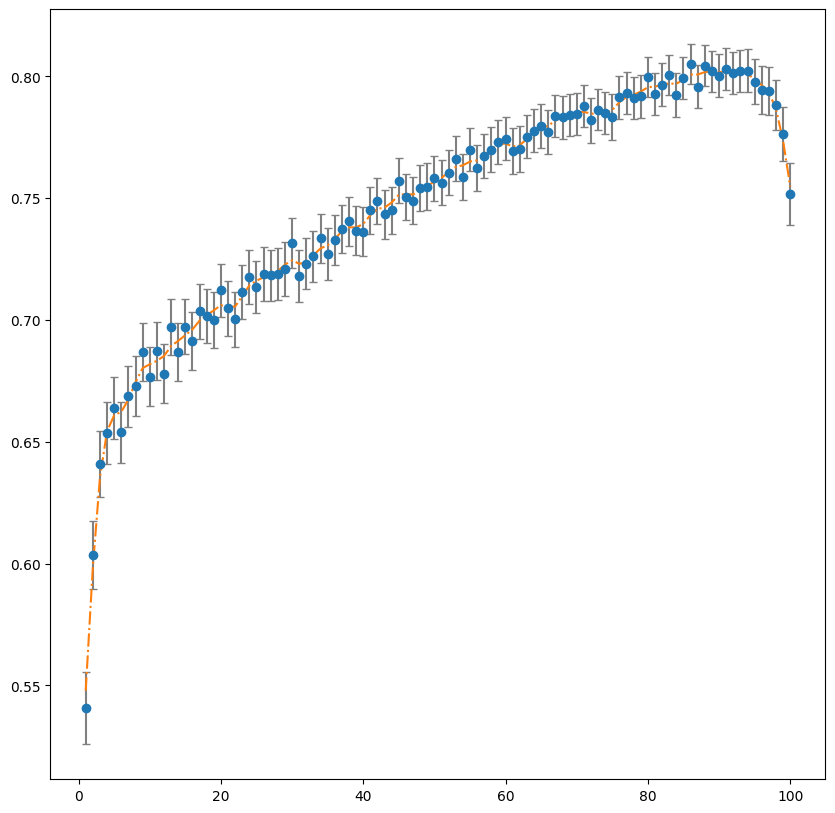

In [4]:
# print(f"\t root_folder: {root_folder} \n \t num_beams_list {num_beams_list} \n \t models: {models} \n \t custom_metrics{[metric.name() for metric in custom_metrics]}"+ 
#     f"\n \t task_names {task_names} \n \t suite_name {suite_name} \n \t instance_metrics {instance_metrics}")
# # instanceGeneration=get_first(processGens.first_run_instances)
# print(examples_df.head(2))
print("num examples" ,len(examples_df))
print(f"compare_metric mean: ",examples_df[[compare_metric]].mean())
print(df.columns)
plot_smooth_spline(df=df, xlabel="rank",groupby='example_idx', ylabel=compare_metric, title="", error_bar=True, figsize=(10,10))



In [5]:
#create dicts
num_ranks=100
pivoted = df.pivot(index="instanceID",columns="rank", values=compare_metric )
mean_pivoted=pivoted.mean()
median_pivoted=pivoted.median()

grouped = df.groupby("example_idx")[["rank", compare_metric, "completion_length"]].mean()



X=df["rank"].values.reshape(-1,1).astype(np.float64)
x=X.reshape(-1)
y=df[compare_metric].values.reshape(-1).astype(np.float64)
metrics={"model_name":model_name}

First, establish the basic facts

In [6]:

#expectation: 
# best_rank=84
# rank100=.75
# rank0=0.53
# corr=positive

ave_val=float(mean_pivoted.mean())
metrics["ave_val"]=ave_val

best_rank = mean_pivoted.idxmax()


metrics["0_score"]= float(mean_pivoted[1])
metrics["100_score"]= float(mean_pivoted[100])
metrics["100_median"]=float(median_pivoted[100])

metrics["best_rank"]=int(best_rank)
metrics["best_score"]=float(mean_pivoted[best_rank])
metrics["best_median"]=float(median_pivoted[100])



def get_win_rate(row, col1:str, col2:str) -> float:
    if row[col1]==row[col2]:
        return 0.5
    return float((row[col1] - row[col2])>0)


pivoted["win_rate_of_best"] = pivoted.apply( lambda row: get_win_rate(row,best_rank, 100) , axis=1)
win_rate=pivoted["win_rate_of_best"].mean()
metrics["win_rate"]=win_rate




Correlation and linear regress

In [7]:
from dcor import distance_correlation
dcor = distance_correlation(X, y)
metrics["dcor"]=float(dcor)


Gam Metrics

In [8]:

from sklearn.metrics import r2_score




# Assuming df is your dataframe
X = grouped["rank"].values.reshape(-1,1)
y = grouped[compare_metric].values.reshape( -1)
x=X.reshape(-1)

gam = LinearGAM(s(0)).gridsearch(X, y)


#R2
y_pred = gam.predict(X)
r2 = r2_score(y,  gam.predict(X))
metrics["r2"]=r2


#find peak
all_x=np.linspace(0,100,1000)
all_y_pred=gam.predict(all_x)
argmax_idx=np.argmax(all_y_pred)
pred_peak_x=all_x[argmax_idx]
pred_peak_y=all_y_pred[argmax_idx]
metrics["pred_peak_x"]=float(pred_peak_x)
metrics["pred_peak_y"]=float(pred_peak_y)
metrics["pred_100"]=float(gam.predict(100)[0])



gam_ave_diff= np.mean(np.abs(all_y_pred-ave_val))

metrics["gam_ave_diff"]=float(gam_ave_diff)


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [9]:
#degen_integral
num_slices=1000
degen_x=np.linspace(pred_peak_x,100,num_slices)
degen_y=gam.predict(degen_x)
ave_diff=np.mean(pred_peak_y-degen_y)

degen_intral=ave_diff*(100-pred_peak_x)/100

metrics["degen_intral"]=degen_intral



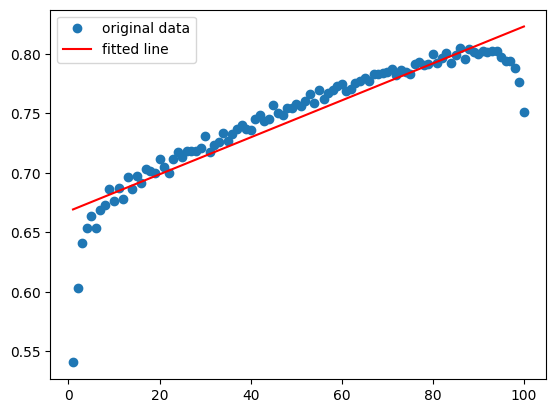

lin_effect is 0.1554127014037764


In [10]:
from scipy.stats import linregress

res=linregress(x, y)
plt.plot(x, y, 'o', label='original data')
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

lin_effect= 100*res.slope

metrics["lin_effect"]=lin_effect

print(f"lin_effect is {lin_effect}")







In [11]:

length_y = grouped["completion_length"].values.reshape( -1)


res=linregress(x, length_y)

length_lin_effect= 100*res.slope
metrics["length_lin_effect"]=length_lin_effect
metrics["length_100"]=length_y[0]
metrics["length_0"]=length_y[-1]
metrics["length_ave"]=np.mean(length_y)



In [12]:
print(df.head(1))

   example_comet  beam_num                    task_name  \
0       0.865341         1  wmt_14_language_pair_de_en_   

                              model  example_idx  rank                 suite  \
0  meta_llama_Llama_3.1_8B_Instruct            0   100  sample_100_eval_1000   

   instanceID                                               text  \
0           0  He advised the parents of a boy whose penis ha...   

   completion_length  output_logprob isCompletion  
0                178       -8.308031         True  


In [14]:
metrics["entropy"]=float(df["output_logprob"].mean())


-60.284106226147934
